# Import

In [1]:
# Basic Library
import os
import pandas as pd
import numpy as np
import pickle
from itertools import permutations, combinations
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer

# HP Tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances

# Modeling
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import xgboost as xgb

In [2]:
def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print("Created Directory :", dir)
    else:
        print("Directory already existed :", dir)
create_dir("../pickle")
create_dir("../model")
create_dir("../submission")

Directory already existed : ../pickle
Directory already existed : ../model
Directory already existed : ../submission


In [3]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
submission = pd.read_csv("../data/sample_submission.csv")

train = train.drop(["id"], axis=1)
test = test.drop(["id"], axis=1)

In [4]:
rows_train = train.shape[0] # 주어진 train data의 row 수
rows_test = test.shape[0] # 주어진 test data의 row 수
num_trial = 100 # 파라미터 튜닝을 몇 번 진행하는지의 수
splits_hp = 5 # 파라미터 튜닝을 진행할 때의 kfold 수
splits_tr = 15 # 모델 트레이닝을 진행할 때의 kfold 수
basic_seed = 42 # default seed
num_seed_hp = 3 # 파라미터 튜닝 seed 개수
num_seed_tr = 10 # 트레이닝 seed 개수
sel_seed = 3 # 선택할 seed 개수

In [5]:
def load_dict(model):
    with open('../pickle/pred_dict_'+model+'.pickle', 'rb') as fw:
        pred_dict_new_local = pickle.load(fw)
    with open('../pickle/pred_test_dict_'+model+'.pickle', 'rb') as fw:
        pred_test_dict_new_local = pickle.load(fw)
    return pred_dict_new_local, pred_test_dict_new_local

In [6]:
pred_dict_lgb, pred_test_dict_lgb = load_dict('lgb')
pred_dict_xgb, pred_test_dict_xgb = load_dict('xgb')
pred_dict_cat, pred_test_dict_cat = load_dict('cat')
pred_dict_nn, pred_test_dict_nn = load_dict('nn')

In [7]:
pred_dict_total = {**pred_dict_lgb, **pred_dict_xgb, **pred_dict_cat, **pred_dict_nn}
pred_test_dict_total = {**pred_test_dict_lgb, **pred_test_dict_xgb, **pred_test_dict_cat, **pred_test_dict_nn}

# Stacking

## (2) HP Tuning

In [9]:
X_train = pd.DataFrame(np.vstack([x for _, x in pred_dict_total.items()]).T)
X_test = pd.DataFrame(np.vstack([x for _, x in pred_test_dict_total.items()]).T)
train_y = train['Target']

In [ ]:
for n, (train_idx, val_idx) in enumerate(kfold.split(X_train, train_y)):
    if n == 0:
        autolgb = AutoLGB(objective='regression', metric='mae',
                      feature_selection=False, n_est=10000, random_state=42)
        autolgb.tune(train_x.iloc[train_idx], train_y[train_idx])
        n_best = autolgb.n_best
        features = autolgb.features
        params = autolgb.params
        print(f'best iteration: {n_best}')
        print(f'selected features ({len(features)}): {features}')        
        print(params)
        autolgb.fit(train_x.iloc[train_idx], train_y[train_idx])
    else:
        train_data = lgb.Dataset(train_x[features].iloc[train_idx], label=train_y[train_idx])
        autolgb = lgb.train(params, train_data, n_best, verbose_eval=100)
        
    pred[val_idx] = autolgb.predict(train_x[features].iloc[val_idx])
    pred_test += autolgb.predict(test_x[features]) / splits_tr

In [10]:
def stack_objective(trial: Trial) -> float:
    score_hp = []
    for seed_hp in np.random.randint(0, 1000, num_seed_hp):
        params_xgb = {
            "random_state": basic_seed,
            "verbose": None,
            "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1), # eta, default=0.3, range=[0,1]
            "gamma": trial.suggest_loguniform("gamma", 1e-2, 1e+2), # min_split_loss, default=0, range=[0,∞]
            "max_depth": trial.suggest_int("max_depth", 4, 10), # default=5, range=[0,∞]
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10), #default=1
            "max_delta_step" : trial.suggest_int("max_delta_step", 0, 10), #default=0
            "subsample": trial.suggest_uniform("subsample", 0.0, 1.0), # default=1, range=(0,1]
            "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.0, 1.0), # default=1, range=(0,1]
            "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.0, 1.0), # default=1, range=(0,1]
            "colsample_bynode": trial.suggest_uniform("colsample_bynode", 0.0, 1.0), # default=1, range=(0,1]
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1e+2), # default=0, range=[0,∞]
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1e+2), # default=1, range=[0,∞]
            "max_bin": trial.suggest_int("max_bin", 100, 400),
        }

        kfold = StratifiedKFold(n_splits=splits_hp, random_state=seed_hp, shuffle=True)
        cv = np.zeros(rows_train)

        for n, (train_idx, val_idx) in enumerate(kfold.split(X_train, train_y)):

            x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train, y_val = train_y.iloc[train_idx], train_y.iloc[val_idx]

            dtrain = xgb.DMatrix(x_train, label=y_train)
            dvalid = xgb.DMatrix(x_val, label=y_val)
            watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
                                                                                                # 진행상황 보고싶을때 None을 100으로
            stack_xgbmodel = xgb.train(params_xgb, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)
            cv[val_idx] = stack_xgbmodel.predict(dvalid)

        score_hp.append(mean_absolute_error(train_y, cv))
    
    np.mean(score_hp)
#     pred_hp_dict['lgb'+str(seed)] = cv
#     print(f'seed {seed}', 'mean_absolute_error :', mean_absolute_error(train_y, cv))
    
#     return mean_absolute_error(train_y, cv)
    return np.mean(score_hp)

In [ ]:
sampler = TPESampler(seed=basic_seed)
stack_study = optuna.create_study(study_name="stack_parameter_opt", direction="minimize", sampler=sampler)
stack_study.optimize(stack_objective, n_trials=num_trial)

stack_best_hyperparams = stack_study.best_trial.params
stack_base_hyperparams = {"random_state": basic_seed}
stack_best_hyperparams.update(stack_base_hyperparams)
print("The best hyperparameters are:\n", stack_best_hyperparams)

with open('../pickle/stack_best_hyperparams.pickle', 'wb') as fw:
    pickle.dump(stack_best_hyperparams, fw)
print("The best hyperparameters are:\n", stack_best_hyperparams)

In [11]:
sampler = TPESampler(seed=basic_seed)
stack_study = optuna.create_study(study_name="stack_parameter_opt", direction="minimize", sampler=sampler)
stack_study.optimize(stack_objective, n_trials=num_trial)

stack_best_hyperparams = stack_study.best_trial.params
stack_base_hyperparams = {"random_state": basic_seed}
stack_best_hyperparams.update(stack_base_hyperparams)
print("The best hyperparameters are:\n", stack_best_hyperparams)

with open('../pickle/stack_best_hyperparams.pickle', 'wb') as fw:
    pickle.dump(stack_best_hyperparams, fw)
print("The best hyperparameters are:\n", stack_best_hyperparams)

[I 2022-03-30 23:28:05,686] A new study created in memory with name: stack_parameter_opt
[I 2022-03-30 23:29:28,129] Trial 0 finished with value: 1.5073306960481125 and parameters: {'learning_rate': 0.005611516415334507, 'gamma': 63.512210106407046, 'max_depth': 9, 'min_child_weight': 6, 'max_delta_step': 1, 'subsample': 0.15599452033620265, 'colsample_bytree': 0.05808361216819946, 'colsample_bylevel': 0.8661761457749352, 'colsample_bynode': 0.6011150117432088, 'reg_alpha': 6.79657809075816, 'reg_lambda': 0.012087541473056965, 'max_bin': 391}. Best is trial 0 with value: 1.5073306960481125.
[I 2022-03-30 23:29:34,223] Trial 1 finished with value: 1.4636256336309583 and parameters: {'learning_rate': 0.04622589001020832, 'gamma': 0.07068974950624607, 'max_depth': 5, 'min_child_weight': 2, 'max_delta_step': 3, 'subsample': 0.5247564316322378, 'colsample_bytree': 0.43194501864211576, 'colsample_bylevel': 0.2912291401980419, 'colsample_bynode': 0.6118528947223795, 'reg_alpha': 0.03613894271

[I 2022-03-30 23:48:45,883] Trial 16 finished with value: 1.4455077013014226 and parameters: {'learning_rate': 0.02278031057530214, 'gamma': 1.967693361317115, 'max_depth': 7, 'min_child_weight': 8, 'max_delta_step': 5, 'subsample': 0.33533336356674726, 'colsample_bytree': 0.7806982255671003, 'colsample_bylevel': 0.37246416754225165, 'colsample_bynode': 0.5243472149842558, 'reg_alpha': 0.4133206909441462, 'reg_lambda': 0.05965608095263569, 'max_bin': 358}. Best is trial 15 with value: 1.4285585885226777.
[I 2022-03-30 23:50:09,719] Trial 17 finished with value: 1.4288714923386754 and parameters: {'learning_rate': 0.002140706644989256, 'gamma': 5.437587652648461, 'max_depth': 8, 'min_child_weight': 9, 'max_delta_step': 4, 'subsample': 0.6890077521417887, 'colsample_bytree': 0.7918373888920287, 'colsample_bylevel': 0.22883160936856095, 'colsample_bynode': 0.23769757502894057, 'reg_alpha': 0.3776998597741803, 'reg_lambda': 0.5786797974584096, 'max_bin': 218}. Best is trial 15 with value: 

KeyboardInterrupt: 

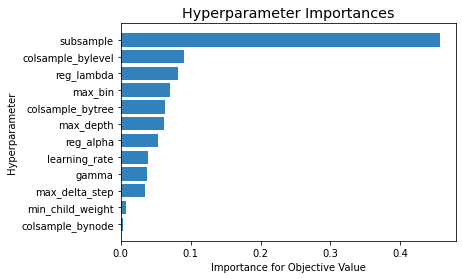

In [13]:
optuna.visualization.matplotlib.plot_param_importances(stack_study);

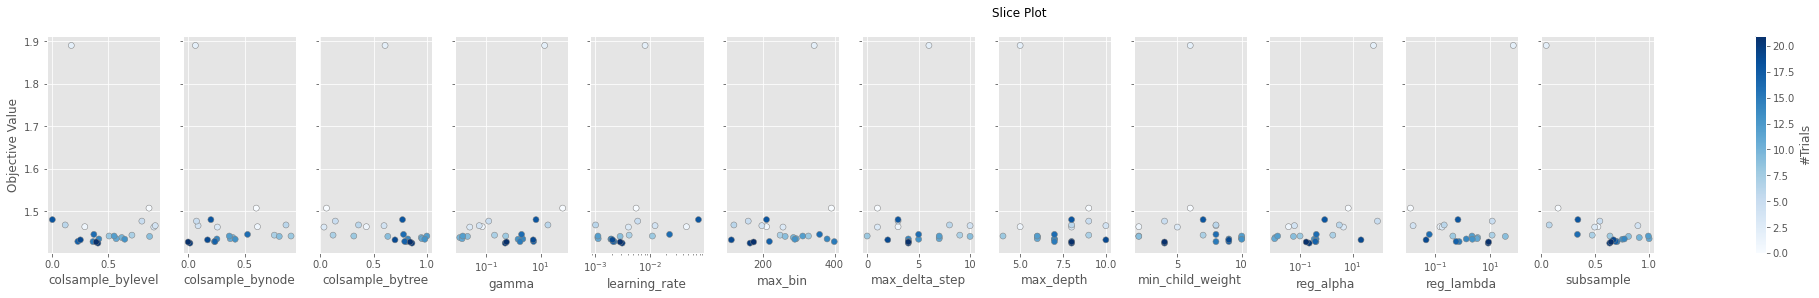

In [14]:
optuna.visualization.matplotlib.plot_slice(stack_study);

In [ ]:
with open('../pickle/stack_best_hyperparams.pickle', 'rb') as fw:
    stack_best_hyperparams = pickle.load(fw)

In [16]:
pred = np.zeros(rows_train)
pred_test = np.zeros(rows_test)
kfold = StratifiedKFold(n_splits=splits_tr, random_state=basic_seed, shuffle = True)

for n, (train_idx, val_idx) in enumerate(kfold.split(X_train, train_y)):
    x_train, x_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train, y_val = train_y.iloc[train_idx], train_y.iloc[val_idx]

    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_val, label=y_val)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
                                                                                        # 진행상황 보고싶을때 None을 100으로
    stack_xgbmodel = xgb.train(stack_best_hyperparams, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)
    
    pred[val_idx] = stack_xgbmodel.predict(dvalid)
    pred_test += stack_xgbmodel.predict(xgb.DMatrix(X_test)) / splits_tr

In [19]:
print(f'CV mean_absolute_error: {mean_absolute_error(train_y, pred):.6f}')

CV mean_absolute_error: 1.426420


# 4. Blending

In [20]:
stack_train = pred.copy()
stack_test = pred_test.copy()

In [54]:
candidate = np.arange(0, 15)
candidate = [0, 1, 2, 3, 10, 50, 80, 100, 500]
permute = permutations(candidate, 5)
score = {}
for i in list(permute):
    pred_permute = (sum(pred_dict_lgb.values())/sel_seed * i[0] +
                    sum(pred_dict_xgb.values())/sel_seed * i[1] +
                    sum(pred_dict_cat.values())/sel_seed * i[2] +
                    sum(pred_dict_nn.values())/sel_seed * i[3] +
                                stack_train * i[4]
                   )
    score[i] = mean_absolute_error(train_y, pred_permute/sum(i))

score = dict(sorted(score.items(), key=lambda x: x[1], reverse=False)[:5])
score

{(10, 0, 1, 500, 80): 1.3862851810672963,
 (10, 1, 0, 500, 80): 1.3862939873208229,
 (3, 0, 1, 500, 80): 1.3862995401129412,
 (3, 1, 0, 500, 80): 1.3863057509552594,
 (10, 0, 2, 500, 80): 1.3863110143705704}

In [55]:
pred = (sum(pred_dict_lgb.values())/sel_seed * list(score.keys())[0][0] +
        sum(pred_dict_xgb.values())/sel_seed * list(score.keys())[0][1] +
        sum(pred_dict_cat.values())/sel_seed * list(score.keys())[0][2] +
        sum(pred_dict_nn.values())/sel_seed * list(score.keys())[0][3] +
        stack_train * list(score.keys())[0][4]
       ) / sum(list(score.keys())[0])
mean_absolute_error(train_y, np.round(pred))

1.3583399840383081

In [58]:
pred_test = (sum(pred_test_dict_lgb.values())/3 * list(score.keys())[0][0] +
             sum(pred_test_dict_xgb.values())/3 * list(score.keys())[0][1] +
             sum(pred_test_dict_cat.values())/3 * list(score.keys())[0][2] +
             sum(pred_test_dict_nn.values())/3 * list(score.keys())[0][3] +
             stack_test * list(score.keys())[0][4]
            ) / sum(list(score.keys())[0])

In [64]:
submission.Target = np.round(pred_test).astype(int)

In [65]:
submission_name = '20220331'
submission_number = '1'
submission.to_csv(f'../submission/{submission_name}-{submission_number}.csv', index = False)